# 機械学習モデルの作成と推論
1. 回帰問題: 特定のフィルターのフラックス予測:

- 目的変数: 例えば、f200w_flux_aper_1 (F200Wフィルターのフラックス)
- 説明変数: 他のフィルターのフラックス（例: f115w_flux_aper_1, f150w_flux_aper_1 など）や天体の形状パラメータ (a_image, b_image など）
- モデル: 線形回帰、決定木、ランダムフォレストなど
- 推論: 学習済みモデルを使って、新しい天体の他のフィルターのフラックスから f200w_flux_aper_1 を予測してみてください。

2. 分類問題: 天体の種類を予測 (簡略化):

- 特徴量: 異なるフィルターのフラックスの色情報（上記の色-色図で作成したような特徴量）
- ラベル (簡略化): 例えば、特定の色の範囲にある天体を「タイプA」、別の範囲にある天体を「タイプB」のように人為的にラベル付けします。
- モデル: ロジスティック回帰、サポートベクターマシン、決定木など
- 推論: 学習済みモデルを使って、新しい天体の色情報から「タイプ」を予測してみてください。

3. クラスタリング: 天体のグループ分け:
- 特徴量: 複数のフィルターのフラックス、形状パラメータ、等級など
- アルゴリズム: K-means、階層的クラスタリングなど
- 推論: 学習済みモデル（クラスタリングの場合は、データのグループ分け）を使って、新しい天体がどのグループに属するかを調べてください。可視化と組み合わせて、各グループの天体の特徴を分析すると面白いでしょう。

## メインプロセスのみ

In [ ]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import multiprocessing


# Check that MPS is available (Apple Silicon GPU を利用可能か確認)
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
else:
    mps_device = torch.device("mps")
# 特徴量として使用する列名
features = [
    'f115w_flux_aper_1',
    'f150w_flux_aper_1',
    'mag_auto',
    'a_image',
    'b_image',
    'peak'
]
# ターゲット変数 (予測したい変数)
target = 'area_auto'

# データセットの読み込み
dataset = HDF5Dataset("ceers.hdf5", features + [target], features + [target])
# DataLoader を使用して、データセットからバッチごとにデータを取り出す (この例ではデータセット全体を1つのバッチとしてロード)
cpu_count = multiprocessing.cpu_count()
print("CPU Count:", cpu_count)
dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=len(dataset), 
    shuffle=True,
)
# DataLoader から 1 バッチ取得
for batch in dataloader:
    data = {key: batch[key].numpy() for key in features + [target]}  # 必要に応じて Tensor を numpy に変換
    break  # 最初のバッチのみ使用
# DataFrameに変換
df = pd.DataFrame(data)
# 欠損値の処理 (NaN を含む行をデータセットから削除)
df = df.dropna()
# 特徴量とターゲットに分割 (モデルの入力となる特徴量と予測したいターゲット変数を分離)
X = df[features].values
y = df[target].values
# データの分割 (トレーニング用とテスト用データに分割。テストデータはモデルの性能評価に使用)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# データの標準化 (特徴量のスケールを揃えることで、モデルの学習を安定させ、性能を向上させる)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# NumPy 配列を PyTorch の Tensor に変換 (PyTorch のモデルで扱えるようにデータ形式を変換)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
# データの確認 (トレーニングデータとテストデータの形状を出力して確認)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
# データの確認 (トレーニングデータとテストデータの形状を出力して確認)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

import torch.nn as nn
# 入力特徴量の数 (モデルの入力層のノード数を決定)
input_size = X_train.shape[1]
# 出力変数の数 (モデルの出力層のノード数を決定。ここでは1つの値を予測)
output_size = 1
# 線形回帰モデルの定義 (PyTorch の nn.Module を継承してモデルを定義)
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        # 線形層 (全結合層) を定義。入力サイズと出力サイズを指定
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # 順伝播処理。入力 x を線形層に通して出力を得る
        return self.linear(x)
# モデルのインスタンスを作成 (定義したモデルクラスのオブジェクトを作成)
model = LinearRegressionModel(input_size, output_size)

# モデルのパラメータ数を表示 (モデルの複雑さを確認)
num_params = sum(p.numel() for p in model.parameters())
print(f'Number of parameters: {num_params}')
# モデルの概要を表示 (モデルの構造を確認)
print(model)

# 損失関数の定義 (回帰問題では平均二乗誤差 (MSE) を使用)
criterion = nn.MSELoss()

# 最適化アルゴリズムの定義 (モデルのパラメータを最適化するためのアルゴリズムを選択。Adam は一般的な選択肢)
learning_rate = 0.01 # 学習率を設定。パラメータの更新幅を制御
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# トレーニングのエポック数 (モデルを学習データで繰り返し学習させる回数)
num_epochs = 1000
losses = [] # 各エポックの損失を記録するためのリスト

# トレーニングループ (指定されたエポック数だけ学習を繰り返す)
for epoch in range(num_epochs):
    # 順伝播 (forward pass) (モデルに入力を与えて予測値を出力)
    outputs = model(X_train)
    # 損失の計算 (モデルの予測値と正解ラベルとの誤差を計算)
    loss = criterion(outputs, y_train)
    # 逆伝播とパラメータ更新 (backward pass and optimization)
    optimizer.zero_grad() # 勾配をゼロに初期化 (前のイテレーションで計算された勾配をリセット)
    loss.backward() # 勾配の計算 (損失関数に基づいて、各パラメータの勾配を計算)
    optimizer.step() # パラメータの更新 (計算された勾配に基づいて、モデルのパラメータを更新)

    losses.append(loss.item()) # 現在のエポックの損失値をリストに追加

    # 一定間隔で損失を出力して学習の進捗を確認
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# モデル全体の保存 (学習済みモデルのパラメータをファイルに保存)
torch.save(model.state_dict(), 'linear_regression_model.pth')
print("Model saved as linear_regression_model.pth")

# 学習曲線のプロット (オプション) (エポックごとの損失の推移をグラフで可視化)
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

### MPS対応

In [ ]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import multiprocessing
from torch.utils.data import DataLoader

# デバイスの設定 (MPS が利用可能なら使用、そうでなければ CPU を使用)
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    device = mps_device
    print("MPS device found and will be used.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA device found and will be used.")
else:
    device = torch.device("cpu")
    print("No GPU found, CPU will be used.")

# 特徴量として使用する列名
features = [
    'f115w_flux_aper_1',
    'f150w_flux_aper_1',
    'mag_auto',
    'a_image',
    'b_image',
    'peak'
]
# ターゲット変数 (予測したい変数)
target = 'area_auto'

# データセットの読み込み
dataset = HDF5Dataset("ceers.hdf5", features + [target], features + [target])
# DataLoader を使用して、データセットからバッチごとにデータを取り出す (この例ではデータセット全体を1つのバッチとしてロード)
cpu_count = multiprocessing.cpu_count()
print("CPU Count:", cpu_count)
dataloader = DataLoader(
    dataset,
    batch_size=len(dataset),
    shuffle=True,
)
# DataLoader から 1 バッチ取得
for batch in dataloader:
    data = {key: batch[key].numpy() for key in features + [target]}  # 必要に応じて Tensor を numpy に変換
    break  # 最初のバッチのみ使用
# DataFrameに変換
df = pd.DataFrame(data)
# 欠損値の処理 (NaN を含む行をデータセットから削除)
df = df.dropna()
# 特徴量とターゲットに分割 (モデルの入力となる特徴量と予測したいターゲット変数を分離)
X = df[features].values
y = df[target].values
# データの分割 (トレーニング用とテスト用データに分割。テストデータはモデルの性能評価に使用)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# データの標準化 (特徴量のスケールを揃えることで、モデルの学習を安定させ、性能を向上させる)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# NumPy 配列を PyTorch の Tensor に変換 (PyTorch のモデルで扱えるようにデータ形式を変換)
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)
# データの確認 (トレーニングデータとテストデータの形状を出力して確認)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
# データの確認 (トレーニングデータとテストデータの形状を出力して確認)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

import torch.nn as nn
# 入力特徴量の数 (モデルの入力層のノード数を決定)
input_size = X_train.shape[1]
# 出力変数の数 (モデルの出力層のノード数を決定。ここでは1つの値を予測)
output_size = 1
# 線形回帰モデルの定義 (PyTorch の nn.Module を継承してモデルを定義)
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        # 線形層 (全結合層) を定義。入力サイズと出力サイズを指定
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # 順伝播処理。入力 x を線形層に通して出力を得る
        return self.linear(x)
# モデルのインスタンスを作成 (定義したモデルクラスのオブジェクトを作成)
model = LinearRegressionModel(input_size, output_size).to(device)

# モデルのパラメータ数を表示 (モデルの複雑さを確認)
num_params = sum(p.numel() for p in model.parameters())
print(f'Number of parameters: {num_params}')
# モデルの概要を表示 (モデルの構造を確認)
print(model)

# 損失関数の定義 (回帰問題では平均二乗誤差 (MSE) を使用)
criterion = nn.MSELoss()

# 最適化アルゴリズムの定義 (モデルのパラメータを最適化するためのアルゴリズムを選択。Adam は一般的な選択肢)
learning_rate = 0.01 # 学習率を設定。パラメータの更新幅を制御
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# トレーニングのエポック数 (モデルを学習データで繰り返し学習させる回数)
num_epochs = 1000
losses = [] # 各エポックの損失を記録するためのリスト

# トレーニングループ (指定されたエポック数だけ学習を繰り返す)
for epoch in range(num_epochs):
    # 順伝播 (forward pass) (モデルに入力を与えて予測値を出力)
    outputs = model(X_train)
    # 損失の計算 (モデルの予測値と正解ラベルとの誤差を計算)
    loss = criterion(outputs, y_train)
    # 逆伝播とパラメータ更新 (backward pass and optimization)
    optimizer.zero_grad() # 勾配をゼロに初期化 (前のイテレーションで計算された勾配をリセット)
    loss.backward() # 勾配の計算 (損失関数に基づいて、各パラメータの勾配を計算)
    optimizer.step() # パラメータの更新 (計算された勾配に基づいて、モデルのパラメータを更新)

    losses.append(loss.item()) # 現在のエポックの損失値をリストに追加

    # 一定間隔で損失を出力して学習の進捗を確認
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# モデル全体の保存 (学習済みモデルのパラメータをファイルに保存)
torch.save(model.state_dict(), 'linear_regression_model.pth')
print("Model saved as linear_regression_model.pth")

# 学習曲線のプロット (オプション) (エポックごとの損失の推移をグラフで可視化)
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

### EPOCH 増加

In [ ]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import multiprocessing
from torch.utils.data import DataLoader
import os

# デバイスの設定 (MPS が利用可能なら使用、そうでなければ CPU を使用)
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    device = mps_device
    print("MPS device found and will be used.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA device found and will be used.")
else:
    device = torch.device("cpu")
    print("No GPU found, CPU will be used.")
device = torch.device("cpu")

# 特徴量として使用する列名
features = [
    'f115w_flux_aper_1',
    'f150w_flux_aper_1',
    'mag_auto',
    'a_image',
    'b_image',
    'peak'
]
# ターゲット変数 (予測したい変数)
target = 'area_auto'

# データセットの読み込み
dataset = HDF5Dataset("ceers.hdf5", features + [target], features + [target])
# DataLoader を使用して、データセットからバッチごとにデータを取り出す (この例ではデータセット全体を1つのバッチとしてロード)
cpu_count = multiprocessing.cpu_count()
print("CPU Count:", cpu_count)
dataloader = DataLoader(
    dataset,
    batch_size=len(dataset),
    shuffle=True,
)
# DataLoader から 1 バッチ取得
for batch in dataloader:
    data = {key: batch[key].numpy() for key in features + [target]}  # 必要に応じて Tensor を numpy に変換
    break  # 最初のバッチのみ使用
# DataFrameに変換
df = pd.DataFrame(data)
# 欠損値の処理 (NaN を含む行をデータセットから削除)
df = df.dropna()
# 特徴量とターゲットに分割 (モデルの入力となる特徴量と予測したいターゲット変数を分離)
X = df[features].values
y = df[target].values
# データの分割 (トレーニング用とテスト用データに分割。テストデータはモデルの性能評価に使用)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# データの標準化 (特徴量のスケールを揃えることで、モデルの学習を安定させ、性能を向上させる)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# NumPy 配列を PyTorch の Tensor に変換 (PyTorch のモデルで扱えるようにデータ形式を変換)
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)
# データの確認 (トレーニングデータとテストデータの形状を出力して確認)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
# データの確認 (トレーニングデータとテストデータの形状を出力して確認)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

import torch.nn as nn
# 入力特徴量の数 (モデルの入力層のノード数を決定)
input_size = X_train.shape[1]
# 出力変数の数 (モデルの出力層のノード数を決定。ここでは1つの値を予測)
output_size = 1
# 線形回帰モデルの定義 (PyTorch の nn.Module を継承してモデルを定義)
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        # 線形層 (全結合層) を定義。入力サイズと出力サイズを指定
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # 順伝播処理。入力 x を線形層に通して出力を得る
        return self.linear(x)
# モデルのインスタンスを作成 (定義したモデルクラスのオブジェクトを作成)
model = LinearRegressionModel(input_size, output_size).to(device)

# モデルのパラメータ数を表示 (モデルの複雑さを確認)
num_params = sum(p.numel() for p in model.parameters())
print(f'Number of parameters: {num_params}')
# モデルの概要を表示 (モデルの構造を確認)
print(model)

# 損失関数の定義 (回帰問題では平均二乗誤差 (MSE) を使用)
criterion = nn.MSELoss()

# 最適化アルゴリズムの定義 (モデルのパラメータを最適化するためのアルゴリズムを選択。Adam は一般的な選択肢)
learning_rate = 0.01 # 学習率を設定。パラメータの更新幅を制御
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 目標とする損失値
target_loss = 0.01  # 例：目標とする損失値を設定
losses = [] # 各エポックの損失を記録するためのリスト
epoch = 0
max_epochs = 10000 # 無限ループを防ぐための最大エポック数
best_loss_file = "best_loss.txt"
model_save_path = "linear_regression_model.pth"
best_loss = float('inf')
best_loss_achieved = False

# 既存のベストロスをファイルからロード
if os.path.exists(best_loss_file):
    with open(best_loss_file, 'r') as f:
        try:
            best_loss = float(f.readline())
            print(f"Loaded best loss from file: {best_loss:.4f}")
        except ValueError:
            print("Could not read best loss from file, starting with infinity.")

# トレーニングループ (目標損失に達するか、最大エポック数に達するまで学習を繰り返す)
while True:
    # 順伝播 (forward pass) (モデルに入力を与えて予測値を出力)
    outputs = model(X_train)
    # 損失の計算 (モデルの予測値と正解ラベルとの誤差を計算)
    loss = criterion(outputs, y_train)
    current_loss = loss.item()

    losses.append(current_loss) # 現在のエポックの損失値をリストに追加

    # 損失が目標値以下になったらループを抜ける
    if current_loss <= target_loss:
        print(f'Epoch [{epoch+1}], Loss: {current_loss:.4f} (Target loss reached)')
        break

    # 現在の損失が過去最高の損失よりも小さい場合にモデルを保存し、ベストロスを更新
    if current_loss < best_loss:
        best_loss = current_loss
        torch.save(model.state_dict(), model_save_path)
        with open(best_loss_file, 'w') as f:
            f.write(str(best_loss))
        print(f'Epoch [{epoch+1}], Loss: {current_loss:.4f} (Best loss so far, model saved)')
        best_loss_achieved = True

    # 逆伝播とパラメータ更新 (backward pass and optimization)
    optimizer.zero_grad() # 勾配をゼロに初期化 (前のイテレーションで計算された勾配をリセット)
    loss.backward() # 勾配の計算 (損失関数に基づいて、各パラメータの勾配を計算)
    optimizer.step() # パラメータの更新 (計算された勾配に基づいて、モデルのパラメータを更新)

    # 一定間隔で損失を出力して学習の進捗を確認
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}], Loss: {current_loss:.4f}')

    epoch += 1

    # 最大エポック数を超えた場合はループを抜ける (過学習を防ぐためにも重要)
    if epoch >= max_epochs:
        print(f'Epoch [{epoch+1}], Loss: {current_loss:.4f} (Max epochs reached)')
        break

print(f"Training finished. Best loss achieved: {best_loss:.4f}")

# max_epochs に達したが best_loss が更新されなかった場合のメッセージ
if epoch >= max_epochs and not best_loss_achieved:
    print("Maximum epochs reached, but no improvement in best loss. Model not saved (or the initial best loss remains).")
elif best_loss_achieved:
    print(f"Model with best loss saved to {model_save_path}")
else:
    # 目標損失に達した場合
    print(f"Model saved to {model_save_path}") # 目標損失に達した場合も保存されているのでメッセージを表示

# モデルを評価モードにする (不要な勾配計算などを抑制)
# モデルを評価モードに設定します。これにより、バッチノーマライゼーションやドロップアウトなどの層が評価モードで動作するようになります
model.eval()
# このブロック内の計算では勾配が計算されません。評価時には不要なため、メモリ使用量を減らし、計算を高速化できます。
with torch.no_grad():
    test_outputs = model(X_test)
    predicted_values = test_outputs.cpu().numpy()
    true_values = y_test.cpu().numpy()

# 予測値 vs. 真値の散布図
# あなたのモデルがテストデータに対して行った予測値と、そのテストデータの実際の正解の値（真値）を比較するためのもの
# 横軸 (True Values): テストデータにおけるターゲット変数（今回の場合は area_auto）の実際の値を示しています
# 縦軸 (Predicted Values): あなたのモデルが同じテストデータに対して予測した area_auto の値を示しています。
# 理想的な結果: もしモデルが完璧であれば、全ての点は左下から右上に向かう対角線上に並びます。この対角線は「予測値 = 真値」を表しています。
plt.figure(figsize=(8, 8))
plt.scatter(true_values, predicted_values)
plt.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'k--', lw=2) # 理想的な対角線
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. True Values')
plt.show()

# 残差プロット
# この図は、モデルの予測誤差（残差）がどのように分布しているかを見るためのものです。残差は「予測値 - 真値」で計算されます。
# 横軸 (Predicted Values): モデルが予測した値を示しています。
# 縦軸 (Residuals): 残差を示しています。残差は「予測値 - 真値」で計算されます。
# 残差が 0 のライン (赤い破線): 理想的な場合、残差は 0 であるべきです。このラインは、モデルが完璧に予測した場合の残差を示しています。
residuals = predicted_values - true_values
plt.figure(figsize=(8, 6))
plt.scatter(predicted_values, residuals)
plt.axhline(y=0, color='r', linestyle='--') # 残差が 0 のライン
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Predicted - True)')
plt.title('Residual Plot')
plt.show()

# 学習曲線のプロット (オプション) (エポックごとの損失の推移をグラフで可視化)
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Ray Tune

In [3]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import shutil
import glob
import datetime
import matplotlib.pyplot as plt
from custom_dataset import HDF5Dataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time  # time モジュールをインポート

# Ray Tune のためのインポート
from ray import tune
from ray.tune.schedulers import ASHAScheduler

# デバイスの設定 (Ray Tune の設定で GPU を利用するかどうかを指定できるため、ここでは CPU に固定)
device = torch.device("cpu")
print("Using CPU for Ray Tune.")

# 特徴量として使用する列名
features = [
    # マグニチュードはフラックスと逆の関係にあるため、暗いオブジェクト（マグニチュードが大きい）ほど、area_auto が小さくなる傾向があるかもしれません。
    'mag_auto',
    'mag_iso',
    # アイソフォタル（等光度）アパーチャによる面積であり、オブジェクトのサイズを測る別の方法です。自動アパーチャによる面積と強い相関があると考えられます。
    'area_iso',
    # Kron 半径は、オブジェクトの光度分布に基づいて定義される半径で、オブジェクトのサイズを示す指標となります。Kron 半径が大きいほど、area_auto も大きくなる傾向があると考えられます。
    'kron_radius',
    # これはオブジェクトを構成するピクセルの数です。ピクセル数が多ければ多いほど、オブジェクトの面積も大きくなるため、area_auto と直接的な関係があると考えられます。
    'npix',
    # これらのパラメータは、画像内でのオブジェクトの範囲を示す最大・最小の x, y 座標です。これらの値からオブジェクトのおおよその面積を推定できるため、area_auto と関連性が高いと考えられます。
    'xmax',
    'xmin',
    'ymax',
    'ymin',
    # これらのパラメータは、画像内のオブジェクトの形状とサイズに関する二次モーメントです。特に x2_image と y2_image は、オブジェクトの広がりを示すため、area_auto と関連する可能性があります。
    'x2_image',
    'y2_image',
    'xy_image',
    # 明るいオブジェクト（フラックスが大きい）ほど、自動検出アルゴリズムによってより広い範囲がオブジェクトとして認識される可能性があり、結果的に area_auto が大きくなることがあります。ただし、点源のようなコンパクトな明るいオブジェクトの場合はこの限りではありません。
    'flux_auto',
    'flux_iso',
    'flux_aper_0',
    'flux_aper_1',
    'flux_aper_2',
    # これらのパラメータは、オブジェクトの全フラックスの一定割合を含む半径を示します。これらの半径が大きいほど、オブジェクトが広がっている可能性があり、area_auto も大きくなる可能性があります。
    'flux_radius',
    'flux_radius_20',
    'flux_radius_90',
]
# ターゲット変数 (予測したい変数)
target = 'area_auto'

# 線形回帰モデルの定義 (PyTorch の nn.Module を継承してモデルを定義)
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        # 線形層 (全結合層) を定義。入力サイズと出力サイズを指定
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # 順伝播処理。入力 x を線形層に通して出力を得る
        return self.linear(x)

# Ray Tune で最適化する train 関数
def train_tune(config):
    start_time = time.time()  # 学習開始時間を記録

    # データセットの読み込み
    dataset = HDF5Dataset(config["data_path"], features + [target], None)
    dataloader = torch.utils.data.DataLoader( # DataLoader を使用
        dataset,
        batch_size=len(dataset),
        shuffle=True,
    )
    for batch in dataloader:
        data = {key: batch[key].numpy() for key in features + [target]}
        break
    df = pd.DataFrame(data)
    df = df.dropna()
    # config に基づいて使用する特徴量のリストを作成
    selected_features = []
    selected_features.append('mag_auto')
    if config["use_mag_iso"]:
        selected_features.append('mag_iso')
    if config["use_area_iso"]:
        selected_features.append('area_iso')
    if config["use_kron_radius"]:
        selected_features.append('kron_radius')
    if config["use_npix"]:
        selected_features.append('npix')
    if config["use_xmax"]:
        selected_features.append('xmax')
    if config["use_xmin"]:
        selected_features.append('xmin')
    if config["use_ymax"]:
        selected_features.append('ymax')
    if config["use_ymin"]:
        selected_features.append('ymin')
    if config["use_x2_image"]:
        selected_features.append('x2_image')
    if config["use_y2_image"]:
        selected_features.append('y2_image')
    if config["use_xy_image"]:
        selected_features.append('xy_image')
    if config["use_flux_auto"]:
        selected_features.append('flux_auto')
    if config["use_flux_iso"]:
        selected_features.append('flux_iso')
    if config["use_flux_aper_0"]:
        selected_features.append('flux_aper_0')
    if config["use_flux_aper_1"]:
        selected_features.append('flux_aper_1')
    if config["use_flux_aper_2"]:
        selected_features.append('flux_aper_2')
    if config["use_flux_radius"]:
        selected_features.append('flux_radius')
    if config["use_flux_radius_20"]:
        selected_features.append('flux_radius_20')
    if config["use_flux_radius_90"]:
        selected_features.append('flux_radius_90')

    X = df[selected_features].values
    y = df[target].values
    # データの分割 (トレーニング用とテスト用データに分割。テストデータはモデルの性能評価に使用)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # データの標準化 (特徴量のスケールを揃えることで、モデルの学習を安定させ、性能を向上させる)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # NumPy 配列を PyTorch の Tensor に変換 (PyTorch のモデルで扱えるようにデータ形式を変換)
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)

    # モデルのインスタンスを作成 (ハイパーパラメータを使用)
    input_size = X_train.shape[1]
    output_size = 1
    model = LinearRegressionModel(input_size, output_size).to(device)

    # 損失関数とオプティマイザの定義 (ハイパーパラメータを使用)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

    best_trial_loss = float('inf')

    # トレーニングループ (ハイパーパラメータを使用)
    for epoch in range(config["epochs"]):
        # 順伝播 (forward pass) (モデルに入力を与えて予測値を出力)
        outputs = model(X_train)
        # 損失の計算 (モデルの予測値と正解ラベルとの誤差を計算)
        loss = criterion(outputs, y_train)
        current_loss = loss.item()
        # 逆伝播とパラメータ更新 (backward pass and optimization)
        optimizer.zero_grad() # 勾配をゼロに初期化 (前のイテレーションで計算された勾配をリセット)
        loss.backward() # 勾配の計算 (損失関数に基づいて、各パラメータの勾配を計算)
        optimizer.step() # パラメータの更新 (計算された勾配に基づいて、モデルのパラメータを更新)

        best_trial_loss = min(best_trial_loss, current_loss)

        # Ray Tune に Loss を報告
        print({"loss": current_loss, "epoch": epoch, "best_loss": best_trial_loss})
        tune.report({"loss": current_loss, "epoch": epoch, "best_loss": best_trial_loss})

    end_time = time.time()  # 学習終了時間を記録
    duration = end_time - start_time
    tune.report({"loss": current_loss, "epoch": epoch, "best_loss": best_trial_loss, "training_duration": duration}) # 学習時間を報告

# ハイパーパラメータの探索空間を定義
# TODO: The number of pre-generated samples (2621440) exceeds
# 3 * 2 * 2 * 2 * 2 * 2 = 3 * 2 * 32 = 96 通り
config = {
    # モデルの学習は、損失関数（モデルの予測と実際のデータのずれを表す関数）の値を最小にするパラメータを見つけるプロセスです
    "learning_rate": tune.grid_search([1e-4, 1e-3, 1e-2]),
    "epochs": tune.grid_search([100, 300]),
    "data_path": "/Users/tozastation/ghq/github.com/tozastation/try-astronomy/auto_area_estimation/ceers.hdf5",
    # 重要と思われるパラメータに絞る
    # "use_mag_iso": True,
    # "use_area_iso": True,
    # "use_kron_radius": True,
    # "use_npix": True,
    "use_mag_iso": tune.grid_search([True, False]),
    "use_area_iso": tune.grid_search([True, False]),
    "use_kron_radius": tune.grid_search([True, False]),
    "use_npix": tune.grid_search([True, False]),
    # 他のパラメータは一旦固定値にするか、探索から外す
    "use_xmax": False,
    "use_xmin": False,
    "use_ymax": False,
    "use_ymin": False,
    "use_x2_image": False,
    "use_y2_image": False,
    "use_xy_image": False,
    "use_flux_auto": False,
    "use_flux_iso": False,
    "use_flux_aper_0": False,
    "use_flux_aper_1": False,
    "use_flux_aper_2": False,
    "use_flux_radius": False,
    "use_flux_radius_20": False,
    "use_flux_radius_90": False,
}

# スケジューラを設定 (リソースを効率的に利用するために ASHA を使用)
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    reduction_factor=2,
    max_t=500  # 最大エポック数を設定 (config の最大値に合わせる)
)

# Ray Tune のトレーニング関数にリソースを指定
trainable_with_resources = tune.with_resources(trainable=train_tune, resources={"cpu": 2, "gpu": 0})

# Ray Tune の実行
tuner = tune.Tuner(
    trainable_with_resources,
    param_space=config,
    tune_config=tune.TuneConfig(
        scheduler=scheduler,
        # Grid Search を使用して全ての組み合わせを探索
        search_alg=tune.search.basic_variant.BasicVariantGenerator(),
        num_samples=1,  # サンプル数を指定
    ),
    run_config=tune.RunConfig(
        # prefix + suffix =<\ctrl3348>-MM-DD_HH-MM-SS
        name="linear_regression_tune-" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"),
    )
)
results = tuner.fit()

# ベストなハイパーパラメータを取得
best_trial = results.get_best_result("best_loss", "min", filter_nan_and_inf=False) # best_loss を指標とする
print(f"Best Trial: {best_trial.metrics}")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss: {best_trial.metrics['best_loss']:.4f}")

# ベストモデルの評価と検証

# ベストなハイパーパラメータを使用してモデルを評価する関数
def evaluate_best_model(best_config, data_path):
    # データセットの読み込み
    dataset = HDF5Dataset(data_path, features + [target], None)
    dataloader = torch.utils.data.DataLoader( # DataLoader を使用
        dataset,
        batch_size=len(dataset),
        shuffle=False, # 評価時はシャッフルしない
    )
    for batch in dataloader:
        data = {key: batch[key].numpy() for key in features + [target]}
        break
    df = pd.DataFrame(data)
    df = df.dropna()

    # ベストな設定に基づいて使用する特徴量のリストを作成
    selected_features = []
    selected_features.append('mag_auto')
    if best_config["use_mag_iso"]:
        selected_features.append('mag_iso')
    if best_config["use_area_iso"]:
        selected_features.append('area_iso')
    if best_config["use_kron_radius"]:
        selected_features.append('kron_radius')
    if best_config["use_npix"]:
        selected_features.append('npix')
    if best_config["use_xmax"]:
        selected_features.append('xmax')
    if best_config["use_xmin"]:
        selected_features.append('xmin')
    if best_config["use_ymax"]:
        selected_features.append('ymax')
    if best_config["use_ymin"]:
        selected_features.append('ymin')
    if best_config["use_x2_image"]:
        selected_features.append('x2_image')
    if best_config["use_y2_image"]:
        selected_features.append('y2_image')
    if best_config["use_xy_image"]:
        selected_features.append('xy_image')
    if best_config["use_flux_auto"]:
        selected_features.append('flux_auto')
    if best_config["use_flux_iso"]:
        selected_features.append('flux_iso')
    if best_config["use_flux_aper_0"]:
        selected_features.append('flux_aper_0')
    if best_config["use_flux_aper_1"]:
        selected_features.append('flux_aper_1')
    if best_config["use_flux_aper_2"]:
        selected_features.append('flux_aper_2')
    if best_config["use_flux_radius"]:
        selected_features.append('flux_radius')
    if best_config["use_flux_radius_20"]:
        selected_features.append('flux_radius_20')
    if best_config["use_flux_radius_90"]:
        selected_features.append('flux_radius_90')

    X = df[selected_features].values
    y = df[target].values
    # データの分割 (トレーニング用とテスト用データに分割。Ray Tune の train 関数と同じ分割方法を使用)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # データの標準化 (トレーニングデータでfitしたscalerをテストデータにも適用)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # NumPy 配列を PyTorch の Tensor に変換
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)

    # モデルのインスタンスを作成 (入力サイズは選択された特徴量の数)
    input_size = len(selected_features)
    output_size = 1
    best_model = LinearRegressionModel(input_size, output_size).to(device)

    # 損失関数を定義
    criterion = nn.MSELoss()

    # 学習済みモデルのロード (Ray Tune は通常、checkpoint を保存するため、そこからロードするのが一般的ですが、
    # 今回は簡単な線形回帰モデルなので、学習済みのパラメータを直接適用します)
    # 注意: Ray Tune は Trial のディレクトリに checkpoint を保存します。
    #       通常は best_trial.checkpoint.to_dict()["state"]["model"] のようにしてロードします。
    #       しかし、今回の train_tune 関数では明示的に保存処理を書いていないため、
    #       ここではベストな設定で再度学習させるか、最後のモデルの状態を利用します。
    #       簡単な例として、ここではベストな設定で再度学習させることにします。

    # モデルの再学習 (ベストなハイパーパラメータを使用)
    optimizer = torch.optim.Adam(best_model.parameters(), lr=best_config["learning_rate"])
    for epoch in range(best_config["epochs"]):
        best_model.train() # モデルを訓練モードに設定
        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)
        outputs = best_model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Epoch [{epoch+1}/{best_config['epochs']}], Loss: {loss.item():.4f}", end='\r')
    print("\nBest model re-trained.")

    # モデルを評価モードに設定
    best_model.eval()
    with torch.no_grad():
        # テストデータで予測
        test_outputs = best_model(X_test_tensor)
        # 損失を計算
        test_loss = criterion(test_outputs, y_test_tensor)
        # 評価指標を計算 (NumPy 配列に変換)
        y_true = y_test_tensor.cpu().numpy()
        y_pred = test_outputs.cpu().numpy()
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

    print("\n--- Best Model Evaluation ---")
    print(f"Test Loss (MSE): {test_loss.item():.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R2): {r2:.4f}")

    # 予測値と真の値の散布図を作成する関数
    def plot_predictions(y_true, y_pred):
        plt.figure(figsize=(8, 8))
        plt.scatter(y_true, y_pred)
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        plt.title("True Values vs. Predicted Values (Best Model)")
        # y=x の線を追加 (理想的な予測を示す)
        lims = [np.min([y_true, y_pred]), np.max([y_true, y_pred])]
        plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
        plt.xlim(lims)
        plt.ylim(lims)
        plt.grid(True)
        plt.show()

    # 散布図を表示
    plot_predictions(y_true, y_pred)

    # モデルの保存判定
    previous_r2_file = "previous_best_r2.txt"
    model_save_path = "best_linear_regression_model.pth"

    try:
        with open(previous_r2_file, "r") as f:
            previous_best_r2 = float(f.readline())
    except FileNotFoundError:
        previous_best_r2 = -float('inf') # まだ記録がない場合は負の無限大とする

    print(f"\nPrevious best R-squared: {previous_best_r2:.4f}")
    print(f"Current R-squared: {r2:.4f}")

    if r2 > previous_best_r2:
        torch.save(best_model.state_dict(), model_save_path)
        with open(previous_r2_file, "w") as f:
            f.write(str(r2))
        print(f"Model saved to {model_save_path}. Updated best R-squared to {r2:.4f} in {previous_r2_file}.")
    else:
        print("Current model's performance is not better than the previous best. Model not saved.")

# 評価関数の実行
evaluate_best_model(best_trial.config, config["data_path"])

2025-04-16 23:31:17,104	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/tozastation/ray_results/linear_regression_tune-2025-04-16_23-30-25' in 0.0055s.
2025-04-16 23:31:17,108	INFO tune.py:1041 -- Total run time: 51.52 seconds (51.51 seconds for the tuning loop).


Best Trial: {'loss': 43267296.0, 'epoch': 99, 'best_loss': 43267296.0, 'training_duration': 20.703666925430298, 'timestamp': 1744813849, 'checkpoint_dir_name': None, 'done': True, 'training_iteration': 101, 'trial_id': '563bb_00000', 'date': '2025-04-16_23-30-49', 'time_this_iter_s': 0.00010609626770019531, 'time_total_s': 20.588662147521973, 'pid': 57419, 'hostname': '3-shake-tozawa.local', 'node_ip': '127.0.0.1', 'config': {'learning_rate': 0.0001, 'epochs': 100, 'data_path': '/Users/tozastation/ghq/github.com/tozastation/try-astronomy/auto_area_estimation/ceers.hdf5'}, 'time_since_restore': 20.588662147521973, 'iterations_since_restore': 101, 'experiment_tag': '0_epochs=100,learning_rate=0.0001'}
Best trial config: {'learning_rate': 0.0001, 'epochs': 100, 'data_path': '/Users/tozastation/ghq/github.com/tozastation/try-astronomy/auto_area_estimation/ceers.hdf5'}
Best trial final validation loss: 43267296.0000

--- Cross-Validation Evaluation ---

Fold 1/5
Epoch [100/100], Loss: 12350

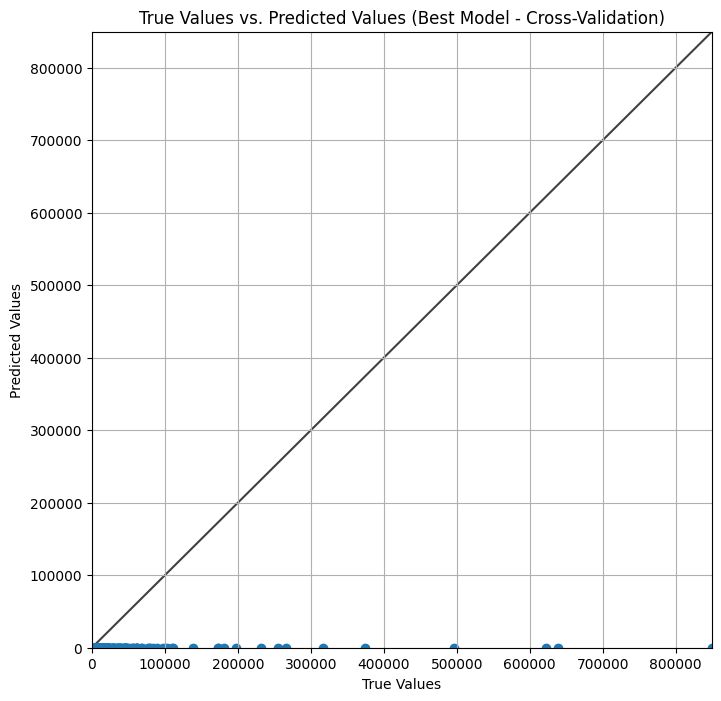


Previous best R-squared: -0.0413
Current average R-squared: -0.0221
Model saved to best_linear_regression_model.pth. Updated best average R-squared to -0.0221 in previous_best_r2.txt.


In [2]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import os
import shutil
import glob
import datetime
import matplotlib.pyplot as plt
from custom_dataset import HDF5Dataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time  # time モジュールをインポート

# Ray Tune のためのインポート
from ray import tune
from ray.tune.schedulers import ASHAScheduler

# デバイスの設定 (Ray Tune の設定で GPU を利用するかどうかを指定できるため、ここでは CPU に固定)
device = torch.device("cpu")
print("Using CPU for Ray Tune.")

# 特徴量として使用する列名
features = [
    'x2_image',
    'y2_image',
    'cxx_image',
    'cyy_image',
    'fluxerr_auto',
    'flux_radius',
    'area_iso',
    'xy_image',
    'npix',
    'flux_aper_1',
]
# ターゲット変数 (予測したい変数)
target = 'area_auto'

# 線形回帰モデルの定義 (PyTorch の nn.Module を継承してモデルを定義)
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        # 線形層 (全結合層) を定義。入力サイズと出力サイズを指定
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # 順伝播処理。入力 x を線形層に通して出力を得る
        return self.linear(x)

# Ray Tune で最適化する train 関数
def train_tune(config):
    start_time = time.time()  # 学習開始時間を記録

    # データセットの読み込み
    dataset = HDF5Dataset(config["data_path"], features + [target], None)
    dataloader = torch.utils.data.DataLoader( # DataLoader を使用
        dataset,
        batch_size=len(dataset),
        shuffle=True,
    )
    for batch in dataloader:
        data = {key: batch[key].numpy() for key in features + [target]}
        break
    df = pd.DataFrame(data)
    df = df.dropna()
    # config に基づいて使用する特徴量のリストを作成
    selected_features = features.copy()  # features をコピーして使用

    X = df[selected_features].values
    y = df[target].values
    # データの分割 (トレーニング用とテスト用データに分割。テストデータはモデルの性能評価に使用)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # データの標準化 (特徴量のスケールを揃えることで、モデルの学習を安定させ、性能を向上させる)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # NumPy 配列を PyTorch の Tensor に変換 (PyTorch のモデルで扱えるようにデータ形式を変換)
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)

    # モデルのインスタンスを作成 (ハイパーパラメータを使用)
    input_size = X_train.shape[1]
    output_size = 1
    model = LinearRegressionModel(input_size, output_size).to(device)

    # 損失関数とオプティマイザの定義 (ハイパーパラメータを使用)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

    best_trial_loss = float('inf')

    # トレーニングループ (ハイパーパラメータを使用)
    for epoch in range(config["epochs"]):
        # 順伝播 (forward pass) (モデルに入力を与えて予測値を出力)
        outputs = model(X_train)
        # 損失の計算 (モデルの予測値と正解ラベルとの誤差を計算)
        loss = criterion(outputs, y_train)
        current_loss = loss.item()
        # 逆伝播とパラメータ更新 (backward pass and optimization)
        optimizer.zero_grad() # 勾配をゼロに初期化 (前のイテレーションで計算された勾配をリセット)
        loss.backward() # 勾配の計算 (損失関数に基づいて、各パラメータの勾配を計算)
        optimizer.step() # パラメータの更新 (計算された勾配に基づいて、モデルのパラメータを更新)

        best_trial_loss = min(best_trial_loss, current_loss)

        # Ray Tune に Loss を報告
        print({"loss": current_loss, "epoch": epoch, "best_loss": best_trial_loss})
        tune.report({"loss": current_loss, "epoch": epoch, "best_loss": best_trial_loss})

    end_time = time.time()  # 学習終了時間を記録
    duration = end_time - start_time
    tune.report({"loss": current_loss, "epoch": epoch, "best_loss": best_trial_loss, "training_duration": duration}) # 学習時間を報告

# ハイパーパラメータの探索空間を定義
# TODO: The number of pre-generated samples (2621440) exceeds
# 3 * 2 * 2 * 2 * 2 * 2 = 3 * 2 * 32 = 96 通り
config = {
    # モデルの学習は、損失関数（モデルの予測と実際のデータのずれを表す関数）の値を最小にするパラメータを見つけるプロセスです
    "learning_rate": tune.grid_search([1e-4, 1e-3, 1e-2]),
    "epochs": tune.grid_search([100, 300]),
    "data_path": "/Users/tozastation/ghq/github.com/tozastation/try-astronomy/auto_area_estimation/ceers.hdf5",
}

# スケジューラを設定 (リソースを効率的に利用するために ASHA を使用)
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    reduction_factor=2,
    max_t=500  # 最大エポック数を設定 (config の最大値に合わせる)
)

# Ray Tune のトレーニング関数にリソースを指定
trainable_with_resources = tune.with_resources(trainable=train_tune, resources={"cpu": 2, "gpu": 0})

# Ray Tune の実行
tuner = tune.Tuner(
    trainable_with_resources,
    param_space=config,
    tune_config=tune.TuneConfig(
        scheduler=scheduler,
        # Grid Search を使用して全ての組み合わせを探索
        search_alg=tune.search.basic_variant.BasicVariantGenerator(),
        num_samples=1,  # サンプル数を指定
    ),
    run_config=tune.RunConfig(
        # prefix + suffix =<\ctrl3348>-MM-DD_HH-MM-SS
        name="linear_regression_tune-" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"),
    )
)
results = tuner.fit()

# ベストなハイパーパラメータを取得
best_trial = results.get_best_result("best_loss", "min", filter_nan_and_inf=False) # best_loss を指標とする
print(f"Best Trial: {best_trial.metrics}")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss: {best_trial.metrics['best_loss']:.4f}")

# ベストモデルの評価と検証

# ベストなハイパーパラメータを使用してモデルを評価する関数
def evaluate_best_model(best_config, data_path, n_splits=5): # n_splits は分割数
    # データセットの読み込み
    dataset = HDF5Dataset(data_path, features + [target], None)
    dataloader = torch.utils.data.DataLoader( # DataLoader を使用
        dataset,
        batch_size=len(dataset),
        shuffle=False, # 評価時はシャッフルしない
    )
    for batch in dataloader:
        data = {key: batch[key].numpy() for key in features + [target]}
        break
    df = pd.DataFrame(data)
    df = df.dropna()

    # ベストな設定に基づいて使用する特徴量のリストを作成
    selected_features = features.copy()  # features をコピーして使用

    X = df[selected_features].values
    y = df[target].values

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    mse_scores = []
    mae_scores = []
    r2_scores = []
    all_y_true = []
    all_y_pred = []

    print("\n--- Cross-Validation Evaluation ---")

    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}/{n_splits}")
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # データの標準化 (各フォールドごとに独立して行う)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        # NumPy 配列を PyTorch の Tensor に変換
        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
        X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)
        y_val_tensor = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1).to(device)

        # モデルのインスタンスを作成
        input_size = len(selected_features)
        output_size = 1
        model = LinearRegressionModel(input_size, output_size).to(device)

        # 損失関数とオプティマイザの定義
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=best_config["learning_rate"])

        # モデルの学習
        for epoch in range(best_config["epochs"]):
            model.train()
            outputs = model(X_train_tensor)
            loss = criterion(outputs, y_train_tensor)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (epoch + 1) % 50 == 0:
                print(f"Epoch [{epoch+1}/{best_config['epochs']}], Loss: {loss.item():.4f}", end='\r')
        print("\nFold training finished.")

        # モデルの評価
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            y_true_fold = y_val_tensor.cpu().numpy()
            y_pred_fold = val_outputs.cpu().numpy()
            mse = mean_squared_error(y_true_fold, y_pred_fold)
            mae = mean_absolute_error(y_true_fold, y_pred_fold)
            r2 = r2_score(y_true_fold, y_pred_fold)
            mse_scores.append(mse)
            mae_scores.append(mae)
            r2_scores.append(r2)
            all_y_true.extend(y_true_fold)
            all_y_pred.extend(y_pred_fold)

        print(f"Fold {fold+1} Validation Loss (MSE): {val_loss.item():.4f}")
        print(f"Fold {fold+1} Mean Squared Error (MSE): {mse:.4f}")
        print(f"Fold {fold+1} Mean Absolute Error (MAE): {mae:.4f}")
        print(f"Fold {fold+1} R-squared (R2): {r2:.4f}")

    # 平均評価指標の計算
    mean_mse = np.mean(mse_scores)
    mean_mae = np.mean(mae_scores)
    mean_r2 = np.mean(r2_scores)

    print("\n--- Average Cross-Validation Results ---")
    print(f"Average Mean Squared Error (MSE): {mean_mse:.4f}")
    print(f"Average Mean Absolute Error (MAE): {mean_mae:.4f}")
    print(f"Average R-squared (R2): {mean_r2:.4f}")

    # 予測値と真の値の散布図を作成
    def plot_predictions(y_true, y_pred):
        plt.figure(figsize=(8, 8))
        plt.scatter(y_true, y_pred)
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        plt.title("True Values vs. Predicted Values (Best Model - Cross-Validation)")
        lims = [np.min([y_true, y_pred]), np.max([y_true, y_pred])]
        plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
        plt.xlim(lims)
        plt.ylim(lims)
        plt.grid(True)
        plt.show()

    plot_predictions(np.array(all_y_true), np.array(all_y_pred))

    # モデルの保存判定 (平均 R2 スコアを使用)
    previous_r2_file = "previous_best_r2.txt"
    model_save_path = "best_linear_regression_model.pth"

    try:
        with open(previous_r2_file, "r") as f:
            previous_best_r2 = float(f.readline())
    except FileNotFoundError:
        previous_best_r2 = -float('inf')

    print(f"\nPrevious best R-squared: {previous_best_r2:.4f}")
    print(f"Current average R-squared: {mean_r2:.4f}")

    # 各フォールドで最も良いモデルを保存するか、平均で判断するかなど、保存戦略を検討する必要があります。
    # ここでは、平均 R2 スコアが改善した場合にモデルを保存する例を示します。
    if mean_r2 > previous_best_r2:
        # どのモデルを保存するかは戦略によります。ここでは、最後に学習したモデルを保存します。
        torch.save(model.state_dict(), model_save_path)
        with open(previous_r2_file, "w") as f:
            f.write(str(mean_r2))
        print(f"Model saved to {model_save_path}. Updated best average R-squared to {mean_r2:.4f} in {previous_r2_file}.")
    else:
        print("Current model's average performance is not better than the previous best. Model not saved.")

# 評価関数の実行 (交差検証の分割数を指定)
evaluate_best_model(best_trial.config, config["data_path"], n_splits=5)